<a href="https://colab.research.google.com/github/kirill-kozlitin/Netology_projects/blob/main/Project1_LinReg_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт библиотек

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

## Предобработка данных

Подгружаем датасет и сморим на него под разными углами

In [2]:
data = pd.read_csv('/adult.csv')

In [3]:
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [5]:
data.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [6]:
for col in data.columns:
  print(data[col].value_counts())

36    1348
35    1337
33    1335
23    1329
31    1325
      ... 
88       6
85       5
87       3
89       2
86       1
Name: age, Length: 74, dtype: int64
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64
203488    21
190290    19
120277    19
125892    18
126569    18
          ..
131379     1
160061     1
334224     1
45381      1
208174     1
Name: fnlwgt, Length: 28523, dtype: int64
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: education, dtype: int64
9     15784


Text(0, 0.5, 'Частота')

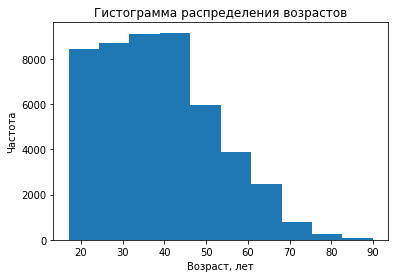

In [7]:
plt.hist(data['age']);
plt.title('Гистограмма распределения возрастов')
plt.xlabel('Возраст, лет')
plt.ylabel('Частота')

Text(0, 0.5, 'Частота')

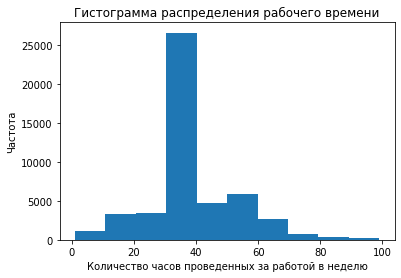

In [8]:
plt.hist(data['hours-per-week']);
plt.title('Гистограмма распределения рабочего времени')
plt.xlabel('Количество часов проведенных за работой в неделю')
plt.ylabel('Частота')

В целом данные выглядят целостно и хорошо. Есть незначительное количество пропусков в виде "?". Таких объектов не много, поэтому просто отбросим их. 

Есть несколько фичей назначение которых нечевидно, например - capital-loss. Оставим, посмотрим как они повлияют на модель. 

Все категориальные фичи закодируем методом OHE. 

In [9]:
for col in data.columns:
  data = data.loc[data[col] != '?']

In [10]:
data.shape

(45222, 15)

Потеряли около 3 тыс. объектов. Менее 10% от общего количества. Будем считать, что допустимо.

In [11]:
data = pd.get_dummies(data, drop_first=True)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 48841
Data columns (total 97 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   age                                        45222 non-null  int64
 1   fnlwgt                                     45222 non-null  int64
 2   educational-num                            45222 non-null  int64
 3   capital-gain                               45222 non-null  int64
 4   capital-loss                               45222 non-null  int64
 5   hours-per-week                             45222 non-null  int64
 6   workclass_Local-gov                        45222 non-null  uint8
 7   workclass_Private                          45222 non-null  uint8
 8   workclass_Self-emp-inc                     45222 non-null  uint8
 9   workclass_Self-emp-not-inc                 45222 non-null  uint8
 10  workclass_State-gov                        452

То что нужно! 

Разбиваем данные на трейн и тест

In [13]:
X = data.drop('income_>50K', axis='columns')
Y = data['income_>50K']

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [15]:
print('x_train.shape:', x_train.shape)
print('x_test.shape:', x_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)


x_train.shape: (36177, 96)
x_test.shape: (9045, 96)
y_train.shape: (36177,)
y_test.shape: (9045,)


Данные разбиты на тренировочную и тестовую выборки; на таргет и фичи. Приступаем к обучению:

## Обучение 

In [16]:
%%time
model_lr = make_pipeline(StandardScaler(), LogisticRegression())

model_lr.fit(x_train, y_train)
print(model_lr.score(x_test, y_test))

0.8509673852957435
CPU times: user 1.49 s, sys: 478 ms, total: 1.97 s
Wall time: 1.14 s


In [17]:
%%time
model_svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))

model_svm.fit(x_train, y_train)
print(model_svm.score(x_test, y_test))

0.8519624101713654
CPU times: user 1min 53s, sys: 427 ms, total: 1min 53s
Wall time: 1min 52s


## Вывод


В процессе работы были обработаны данные:
1.   Удалены пропуски
2.   Категориальные фичи преобразованы OHE



Далее было обучено 2 модели. Оценка точности показывает практически идентичные результаты (до сотых долей). Однако, время обучения моделей сильно разное - у SVM почти в 100 раз больше! 